In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned_2.csv', low_memory=False)

In [3]:
data = df.copy()

In [4]:
pd.set_option('display.max_columns', None)
data.head(3)

,primaryid,caseid,caseversion,age,age_grp,sex,occp_cod,seq,role_cod,drugname,prod_ai,route,indi_pt,outc_cod,pt,rept_yr,SOC
0,100735935,10073593,5,55.0,adult,female,consumer,1,ps,humira,adalimumab,subcutaneous,rheumatoid arthritis,ot,arterial occlusive disease,2020,Vascular disorders
1,100735935,10073593,5,55.0,adult,female,consumer,1,ps,humira,adalimumab,subcutaneous,rheumatoid arthritis,ot,carotid artery occlusion,2020,Vascular disorders
2,100735935,10073593,5,55.0,adult,female,consumer,1,ps,humira,adalimumab,subcutaneous,rheumatoid arthritis,ot,cataract,2020,Eye disorders


### 1. Gather information

In [18]:
# Gather columns 
group_cols = [col for col in data.columns if col not in ['pt', 'SOC', 'outc_cod']]

merged_df = data.groupby(group_cols, as_index=False).agg({
    'outc_cod': lambda x: list(x),
    'pt': lambda x: list(x),
    'SOC': lambda x: list(x)
})

# Drop duplicates in lists
merged_df['outc_cod'] = merged_df['outc_cod'].apply(lambda x: list(dict.fromkeys(x)))
merged_df['pt'] = merged_df['pt'].apply(lambda x: list(dict.fromkeys(x)))
merged_df['SOC'] = merged_df['SOC'].apply(lambda x: list(dict.fromkeys(x)))

### 1. Reports and demographic

In [19]:
data_2 = merged_df.copy()

In [20]:
# Number of reports
print(f'Number of reports: {data_2['primaryid'].nunique()}')

Number of reports: 191727


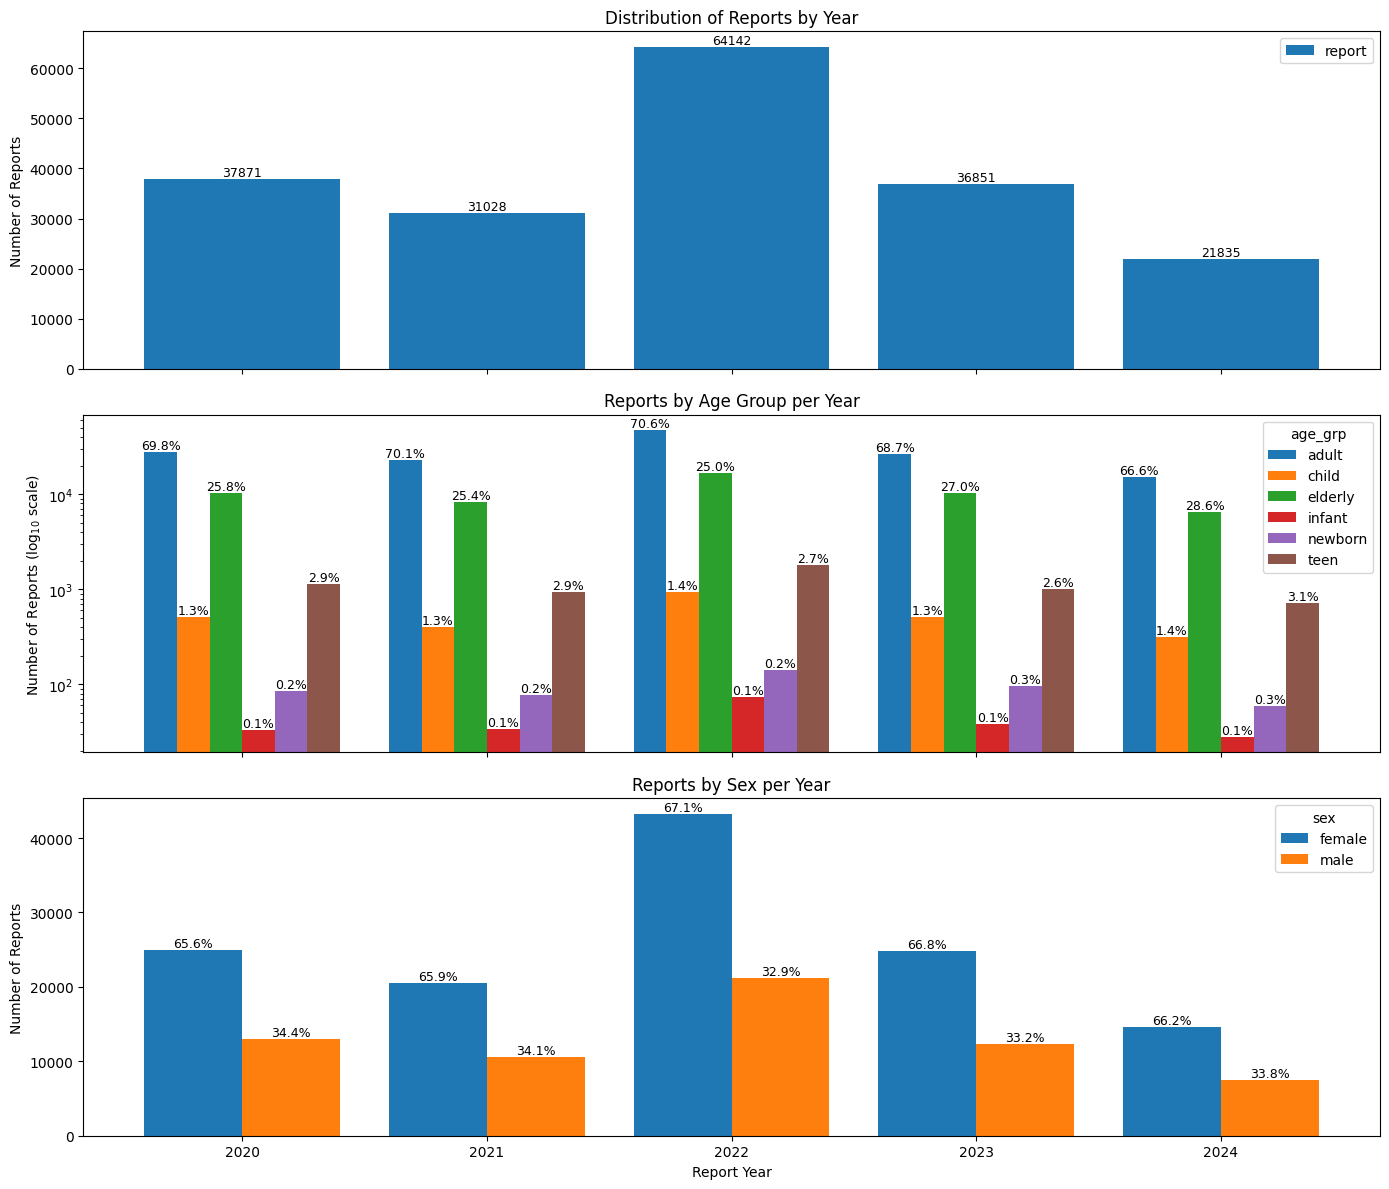

In [82]:
# Distribution of reports by year
reports_by_year = data_2[['primaryid', 'rept_yr']].drop_duplicates()
report_counts = reports_by_year['rept_yr'].value_counts().sort_index()

# Age 
age_grp_yrs = data_2[['primaryid', 'rept_yr', 'age_grp']].drop_duplicates()
age_groups = age_grp_yrs.groupby(['rept_yr', 'age_grp']).size().reset_index(name='count')
pivot_age = age_groups.pivot(index='rept_yr', columns='age_grp', values='count').fillna(0)
pivot_age_percent = pivot_age.div(pivot_age.sum(axis=1), axis=0) * 100

# Sex 
sex_yrs = data_2[['primaryid', 'rept_yr', 'sex']].drop_duplicates()
sex_groups = sex_yrs.groupby(['rept_yr', 'sex']).size().reset_index(name='count')
pivot_sex = sex_groups.pivot(index='rept_yr', columns='sex', values='count').fillna(0)
pivot_sex_percent = pivot_sex.div(pivot_sex.sum(axis=1), axis=0) * 100

# Plot
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

## Reports
bars_report = report_counts.to_frame('report').plot(kind='bar', width=0.8, ax=axes[0])
axes[0].set_ylabel('Number of Reports')
axes[0].set_title('Distribution of Reports by Year')

for container in bars_report.containers:
    for rect in container:
        height = rect.get_height()
        if height > 0:
            axes[0].text(rect.get_x() + rect.get_width()/2, height, f'{int(height)}',
                         ha='center', va='bottom', fontsize=9)

## Age
bars_age = pivot_age.plot(kind='bar', width=0.8, ax=axes[1], logy=True)
axes[1].set_ylabel('Number of Reports (log$_{10}$ scale)')
axes[1].set_title('Reports by Age Group per Year')

for container, col in zip(bars_age.containers, pivot_age.columns):
    for rect, pct in zip(container, pivot_age_percent[col]):
        height = rect.get_height()
        if height > 0:
            axes[1].text(rect.get_x() + rect.get_width()/2, height, f'{pct:.1f}%',
                         ha='center', va='bottom', fontsize=9)

## Sex
bars_sex = pivot_sex.plot(kind='bar', width=0.8, ax=axes[2])
axes[2].set_ylabel('Number of Reports')
axes[2].set_xlabel('Report Year')
axes[2].set_title('Reports by Sex per Year')

for container, col in zip(bars_sex.containers, pivot_sex.columns):
    for rect, pct in zip(container, pivot_sex_percent[col]):
        height = rect.get_height()
        if height > 0:
            axes[2].text(rect.get_x() + rect.get_width()/2, height, f'{pct:.1f}%',
                         ha='center', va='bottom', fontsize=9)

for ax in axes:
    ax.set_xticks(range(len(pivot_age.index)))
    ax.set_xticklabels(pivot_age.index.astype(int), rotation=0)

plt.tight_layout()
plt.show()


In [25]:
# Ratio of reports by age group
adults = age_grp_yrs[age_grp_yrs['age_grp'] == 'adult']
adults_pct = (len(adults) / len(age_grp_yrs)) * 100

elderly = age_grp_yrs[age_grp_yrs['age_grp'] == 'elderly']
elderly_pct = (len(elderly) / len(age_grp_yrs)) * 100

print(f'Ratio of reports for adult patients: {adults_pct:.2f}%')
print(f'Ratio of reports for elderly patients: {elderly_pct:.2f}%')

Ratio of reports for adult patients: 69.54%
Ratio of reports for elderly patients: 26.00%


In [83]:
# Ratio of reports by sex
male = sex_yrs[sex_yrs['sex'] == 'male']
male_pct = (len(male) / len(sex_yrs)) * 100

female = sex_yrs[sex_yrs['sex'] == 'female']
female_pct = (len(female) / len(sex_yrs)) * 100

print(f'Ratio of reports for male patients: {male_pct:.2f}%')
print(f'Ratio of reports for female patients: {female_pct:.2f}%')

Ratio of reports for male patients: 33.55%
Ratio of reports for female patients: 66.45%


### 4. Indication

<Figure size 1200x600 with 0 Axes>

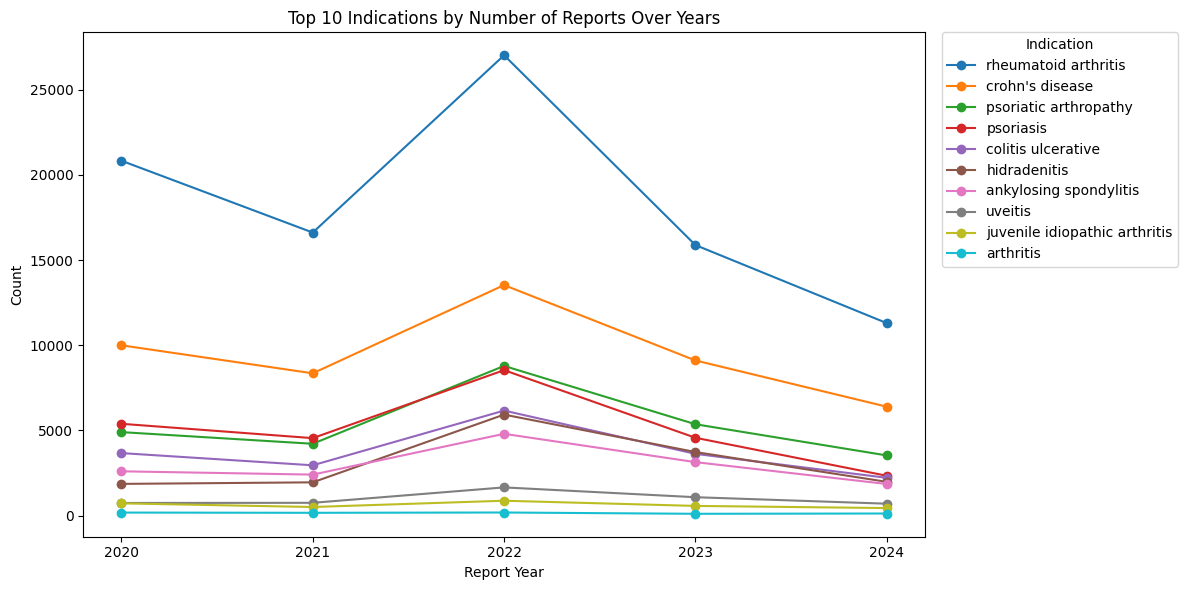

In [ ]:
# Group and pivot
indi_yrs = data[['primaryid', 'rept_yr', 'indi_pt']].drop_duplicates()
indi = indi_yrs.groupby(['rept_yr', 'indi_pt']).size().reset_index(name='count')
pivot_indi = indi.pivot(index='rept_yr', columns='indi_pt', values='count').fillna(0)

# Get top 10 indications 
top_10_indi = pivot_indi.sum().sort_values(ascending=False).head(10).index
pivot_top10_indi = pivot_indi[top_10_indi]

# Plot
plt.figure(figsize=(12, 6))
ax = pivot_top10_indi.plot(kind='line', marker='o', figsize=(12, 6))

# Set integer x-axis ticks
ax.set_xticks(pivot_top10_indi.index)
ax.set_xticklabels(pivot_top10_indi.index.astype(int))

plt.title('Top 10 indications by number of reports over years')
plt.xlabel('Report year')
plt.ylabel('Count')

# Move legend to the right
plt.legend(title='Indication', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

In [13]:
indi_yrs['indi_pt'].value_counts().head(10)

indi_pt
rheumatoid arthritis             91666
crohn's disease                  47388
psoriatic arthropathy            26800
psoriasis                        25383
colitis ulcerative               18628
hidradenitis                     15453
ankylosing spondylitis           14799
uveitis                           4922
juvenile idiopathic arthritis     3103
arthritis                          748
Name: count, dtype: int64

In [94]:
len(indi_yrs[indi_yrs['indi_pt'] == 'rheumatoid arthritis'])

91666

In [93]:
len(indi_yrs[indi_yrs['indi_pt'] == 'rheumatoid arthritis']) / len(indi_yrs) * 100

34.75290504805414

### 5. Preferred Terms

<Figure size 1200x600 with 0 Axes>

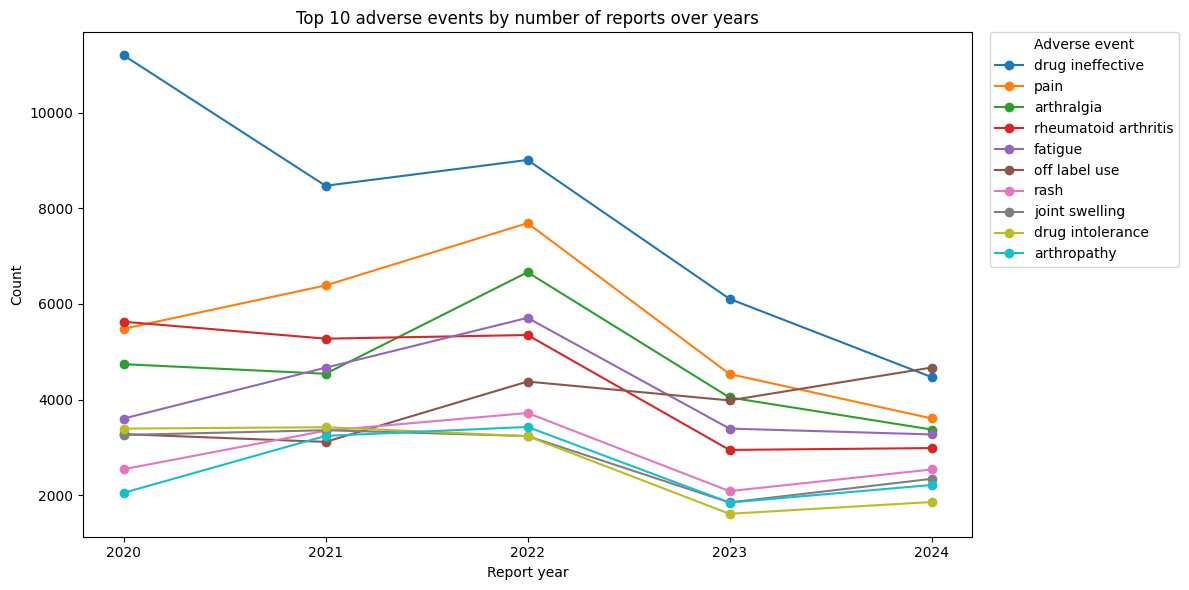

In [96]:
# Group and pivot
pt_yrs = data[['primaryid', 'rept_yr', 'pt']].drop_duplicates()
pt = pt_yrs.groupby(['rept_yr', 'pt']).size().reset_index(name='count')
pivot_indi = pt.pivot(index='rept_yr', columns='pt', values='count').fillna(0)

# Get top 10 indications 
top_10_pt = pivot_indi.sum().sort_values(ascending=False).head(10).index
pivot_top10_pt = pivot_indi[top_10_pt]

# Plot
plt.figure(figsize=(12, 6))
ax = pivot_top10_pt.plot(kind='line', marker='o', figsize=(12, 6))

# Set integer x-axis ticks
ax.set_xticks(pivot_top10_pt.index)
ax.set_xticklabels(pivot_top10_pt.index.astype(int))

plt.title('Top 10 adverse events by number of reports over years')
plt.xlabel('Report year')
plt.ylabel('Count')

# Move legend to the right
plt.legend(title='Adverse event', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()